In [1]:
import os

data_dir = 'E:/Study/study/python/NLP/deeplearning_record/Downloads/jena_climate'
fname = os.path.join(data_dir,'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))
#观察数据

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
import numpy as np
float_data = np.zeros((len(lines),len(header)-1))

for i, line in enumerate(lines):
#enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标，一般用在 for 循环当中
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
    

In [3]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [4]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if(max_index is None):
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while(1):
        if shuffle:
            rows = np.random.randint(min_index+lookback,max_index,size=batch_size)
        else:
            if i+ batch_size >= max_index:
                i = min_index+ lookback
            rows = np.arange(i,min(i+batch_size,max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
                            lookback//step,
                           data.shape[-1]))
        #zers((a,b,c));a,b,c表示由外到内的元素个数
        targets = np.zeros((len(rows),))
        for j,row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j]+delay][1]
        yield samples, targets

In [5]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,delay=delay,lookback=lookback,min_index=0,max_index=200000,step=step,batch_size=batch_size)
val_gen = generator(float_data,delay=delay,lookback=lookback,min_index=200001,max_index=300000,step=step,batch_size=batch_size)
test_gen = generator(float_data,delay=delay,lookback=lookback,min_index=300001,max_index=None,step=step,batch_size=batch_size)

val_steps = (300000-200001-lookback) // batch_size
test_steps = (len(float_data)-300001-lookback) // batch_size

In [6]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32,5, activation='relu',
                        input_shape=(None,float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32,5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32,5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),
              loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                   epochs=20,
                   validation_data=val_gen,
                   validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 18s 36ms/step - loss: 0.3654 - val_loss: 0.8414
Epoch 2/20
500/500 [==============================] - 18s 36ms/step - loss: 0.3867 - val_loss: 0.9860
Epoch 3/20
500/500 [==============================] - 20s 40ms/step - loss: 0.3789 - val_loss: 1.0794
Epoch 4/20
500/500 [==============================] - 18s 35ms/step - loss: 0.3747 - val_loss: 1.1785
Epoch 5/20
500/500 [==============================] - 20s 39ms/step - loss: 0.3832 - val_loss: 1.2351
Epoch 6/20
500/500 [==============================] - 18s 37ms/step - loss: 0.3750 - val_loss: 0.9121
Epoch 7/20
500/500 [==============================] - 17s 35ms/step - loss: 0.3757 - val_loss: 0.8330
Epoch 8/20
500/500 [==============================] - 18s 35ms/step - loss: 0.3632 - val_loss: 1.4399
Epoch 9/20
500/500 [==============================] - 18s 36ms/step - loss: 0.3914 - val_loss: 0.9466
Epoch 10/20
500/500 [==============================] - 18s 36ms/step - loss: 0.374

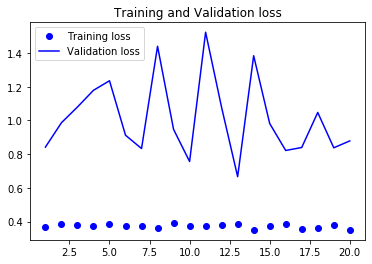

In [9]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [15]:
step = 3
lookback = 720
delay =144

train_gen = generator(float_data,
            lookback=lookback,
            delay=delay,
            min_index=0,
            max_index=200000,
            shuffle=True,
            step=step)

val_gen = generator(float_data,
                   lookback=lookback,
                   delay=delay,
                   min_index=200001,
                   max_index=300000,
                   step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step)

val_steps= (300000 - 200001- lookback) // 128
test_steps = (len(float_data)-300001 - lookback) // 128

In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32,5, activation='relu',
                        input_shape=(None,float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32,5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1,recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(),loss='mae')
history = model.fit_generator(train_gen,
                   steps_per_epoch=500,
                   epochs=20,
                   validation_data=val_gen,
                   validation_steps=val_steps)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 252s 503ms/step - loss: 0.3312 - val_loss: 0.2880
Epoch 2/20
5